Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Zihan Zhou"
COLLABORATORS = "Yihui Zhu, Xinyue Zhang"

---

# Homework 2: Food Safety 

## Course Policies

Here are some important course policies. These are also located at
http://www.ds100.org/sp18/.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.


## Due Date

This assignment is due at 11:59pm Tuesday, February 6th. Instructions for submission are on the website.

# Homework 2: Food Safety 
## Cleaning and Exploring Data with Pandas

<img src="scoreCard.jpg" width=400>

In this homework, you will investigate restaurant food safety scores for restaurants in San Francisco. Above is a sample score card for a restaurant. The scores and violation information have been made available by the San Francisco Department of Public Health, and we have made these data available to you via the DS 100 repository. The main goal for this assignment is to understand how restaurants are scored. We will walk through the various steps of exploratory data analysis to do this. To give you a sense of how we think about each discovery we make and what next steps it leads to we will provide comments and insights along the way.

As we clean and explore these data, you will gain practice with:
* Reading simple csv files
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Exploring characteristics and distributions of individual variables

### Question 0

To start the assignment, run the cell below to set up some imports and the automatic tests that we will need for this assignment:

In many of these assignments (and your future adventures as a data scientist) you will use os, zipfile, pandas, numpy, matplotlib.pyplot, and seaborn.  

1. Import each of these libraries `as` their commonly used abbreviations (e.g., `pd`, `np`, `plt`, and `sns`).  
1. Don't forget to use the jupyter notebook "magic" to enable [inline matploblib plots](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib). 
1. Add the line `sns.set()` to make your plots look nicer.

In [2]:
# YOUR CODE HERE
%matplotlib inline
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import sys

assert 'zipfile'in sys.modules
assert 'pandas'in sys.modules and pd
assert 'numpy'in sys.modules and np
assert 'matplotlib'in sys.modules and plt
assert 'seaborn'in sys.modules and sns

## Downloading the data

As you saw in lectures, we can download data from the internet with Python.  
Using the `utils.py` file from the lectures (see [link](http://www.ds100.org/sp18/assets/lectures/lec05/utils.py)), define a helper function `fetch_and_cache` to download the data with the following arguments:
- data_url: the web address to download
- file: the file in which to save the results
- data_dir: (default="data") the location to save the data
- force: if true the file is always re-downloaded 

This function should return `pathlib.Path` object representing the file.

In [4]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path object representing the file.
    """
    
    # YOUR CODE HERE
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time 
        birth_time = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded:", birth_time)
    return file_path

Now use the previously defined function to download the data from the following URL: https://extxfer.sfdph.org/food/SFBusinesses.zip

In [5]:
data_url = 'https://extxfer.sfdph.org/food/SFBusinesses.zip'
file_name = 'data.zip'
data_dir = '.'


dest_path = fetch_and_cache(data_url=data_url, data_dir=data_dir, file=file_name)
print('Saved at {}'.format(dest_path))

Using cached version downloaded: Wed Jan 31 04:37:42 2018
Saved at data.zip


## Loading Food Safety Data

To begin our investigation, we need to understand the structure of the data. Recall this involves answering questions such as 

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

There are 4 files in the data directory.  Let's use Python to understand how this data is laid out.

Use the `zipfile` library to list all the files stored in the `dest_path` directory.

Creating a ZipFile object might be a good start (the [Python docs](https://docs.python.org/3/library/zipfile.html) have further details).

In [6]:
# Fill in the list_files variable with a list of all the names of the files in the zip file
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = [x for x in my_zip.namelist()]

# YOUR CODE HERE

In [7]:
assert isinstance(my_zip, zipfile.ZipFile)
assert isinstance(list_names, list)
assert all([isinstance(file, str) for file in list_names]) 


Now display the files' names and their sizes.

You might want to check the attributes of a `ZipFile` object.

In [8]:
# YOUR CODE HERE
print(list_names)
print([x.file_size for x in my_zip.filelist])

['violations.csv', 'businesses.csv', 'inspections.csv', 'legend.csv']
[3727570, 660000, 466531, 120]


### Question 1a

From the above output we see that one of the files is relatively small.

Still based on the [HTML notebook](http://www.ds100.org/sp18/assets/lectures/lec03/03-live-datatables-indexes-pandas.html) of Prof. Perez, display the 5 first lines of this file.

In [9]:
# YOUR CODE HERE

file_to_open = 'legend.csv'
with my_zip.open(file_to_open) as f:
    for i in range(5):
        print(f.readline().rstrip().decode())

"Minimum_Score","Maximum_Score","Description"
0,70,"Poor"
71,85,"Needs Improvement"
86,90,"Adequate"
91,100,"Good"


In [10]:
assert isinstance(file_to_open, str)


Let us define a function to perform this.

Using the `utils.py` file from the lectures (see [link]()), define a `head` function to display the first lines of the content of a file.

In [11]:
def head(filename, lines=5):
    """
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.
    """
    # YOUR CODE HERE
    from itertools import islice
    with open(filename, "r") as f:
        return list(islice(f, lines))
    
head(file_to_open)

['"Minimum_Score","Maximum_Score","Description"\n',
 '0,70,"Poor"\n',
 '71,85,"Needs Improvement"\n',
 '86,90,"Adequate"\n',
 '91,100,"Good"\n']

### Question 1b

Use the `head` function to verify that the remaining files are also CSV formatted as their file extension suggests.

We will extract the content of the zip file to a `data` directory.

In [12]:
data_dir = Path('data')
my_zip.extractall(data_dir)

# YOUR CODE HERE
!head data/*

==> data/businesses.csv <==











==> data/inspections.csv <==











==> data/legend.csv <==






==> data/violations.csv <==












Answer the following boolean expressions using `True` or `False`.

In [13]:
# Are all the files CSV files?
all_files_appear_to_be_csv = True

# Do all the files have a header line?
all_files_contain_headers = True

# Do all the strings in the file have quotes around them?
strings_appear_quoted = True

# YOUR CODE HERE

Do not edit the empty cell below.

### Question 1c

Based on the above information let's attempt to load the `businesses.csv`, `inspections.csv`, and the `violations.csv` into pandas data frames with the following names `bus`, `ins`, and `vio`.

*Note:* Because of character encoding issues one of the files will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. 

In [14]:
# path to directory containing data
dsDir = Path('data')

# Make sure to use these names
bus = pd.read_csv('data/businesses.csv', encoding='ISO-8859-1')
ins = pd.read_csv('data/inspections.csv', encoding='ISO-8859-1')
vio = pd.read_csv('data/violations.csv', encoding='ISO-8859-1')
# YOUR CODE HERE

Now, we perform some sanity checks for you to verify that you loaded the data with the right structure. First, run the following cells to load some basic utilities (you do not need to change these at all):

In [15]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""

def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """
    import numpy.testing as npt
    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    npt.assert_allclose(act, des, rtol)

First, we check the basic structure of the data frames you got:

In [16]:
assert all(bus.columns == ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6400 <= len(bus) <= 6420

assert all(ins.columns == ['business_id', 'score', 'date', 'type'])
assert 14210 <= len(ins) <= 14250

assert all(vio.columns == ['business_id', 'date', 'description'])
assert 39020 <= len(vio) <= 39080

Numerical tests: the following are hand-computed statistical summaries of the correct data. Your own data variables `bus`, `ins` and `vio` should provide similar results with the `describe()` method. Let's look at these once so you can compare. Once you have it all working, you can run the tests in the next cell to verify it numerically.

In [17]:
bus_summary = pd.DataFrame(**{'columns': ['business_id', 'latitude', 'longitude'],
 'data': {'business_id': {'50%': 68294.5, 'max': 94574.0, 'min': 19.0},
  'latitude': {'50%': 37.780435, 'max': 37.824494, 'min': 37.668824},
  'longitude': {'50%': -122.41885450000001,
   'max': -122.368257,
   'min': -122.510896}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['business_id', 'score'],
 'data': {'business_id': {'50%': 61462.0, 'max': 94231.0, 'min': 19.0},
  'score': {'50%': 92.0, 'max': 100.0, 'min': 48.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['business_id'],
 'data': {'business_id': {'50%': 62060.0, 'max': 94231.0, 'min': 19.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('Businesses:')
display(bus_summary)
print('Inspections:')
display(ins_summary)
print('Violations:')
display(vio_summary)

Businesses:


,business_id,latitude,longitude
min,19.0,37.668824,-122.510896
50%,68294.5,37.780435,-122.418855
max,94574.0,37.824494,-122.368257


Inspections:


,business_id,score
min,19.0,48.0
50%,61462.0,92.0
max,94231.0,100.0


Violations:


,business_id
min,19.0
50%,62060.0
max,94231.0


Numerical tests: the following cell provides summary values that you should be able to match for the three main datasets. We will conduct other tests internally, but you should have loaded your data in a way that matches these few summary statistics.

In [18]:
# These tests will raise an exception if your variables don't match numerically the correct
# answers in the main summary statistics shown above.
df_allclose(bus, bus_summary)
df_allclose(ins, ins_summary)
df_allclose(vio, vio_summary)

Do not edit the empty cell below.

Run the following cells in order to view a portion of each dataframe.

In [19]:
bus.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


In [20]:
ins.head(5)

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


In [21]:
vio.head(5)

,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unclean or degraded floors walls or ceilings ...
3,19,20160513,Food safety certificate or food handler card n...
4,19,20160513,Unapproved or unmaintained equipment or utensi...


### Question 1d

In the following describe at least one potential problem with the above data. Consider issues with missing values and bad data.  

In [22]:
q1d_answer = r"""

In businesses, the phone number of id-31 is missing.

"""

# YOUR CODE HERE

print(q1d_answer)



In businesses, the phone number of id-31 is missing.




We will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables indivdually. Let's begin with the businesses file, which has been read into the data.frame `bus`.

## Examining the Business data

From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

**Important note: From now on, the local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Question 2

#### Question 2a

Examining the entries in in the `businesses.csv` table `bus` is the `business_id` unique for each record?

`... # use value_counts() or unique() to determine if the business_id field is unique`

In [23]:
is_business_id_unique = True

# YOUR CODE HERE
len(bus['business_id'].unique()) == len(bus['business_id'])

True

In [24]:
assert is_business_id_unique

#### Question 2b

With this information, you can address the question of granularity and so answer the questions below.

1. What is the granularity of the businesses data frame? 
1. How many records are there?
1. What does each record represent (e.g., a store, a chain, a transaction)?  
1. What is the primary key?

Please write your answer in the `q2b_answer` variable. You may create new cells to run code as long as you don't delete the cell below.

In [25]:
# use this cell for scratch work
# consider using groupby or value_counts() on the 'name' or 'business_id' 
bus['name'].size

# YOUR CODE HERE

6404

In [26]:
q2b_answer = r"""

The granularity of the business data frame is high, with address, city, state, postal code, latitude, longitude, 
and phone_number presented.
There are 6404 records.
Each record represent a restaurant.
The primary key is the business id.

"""

# YOUR CODE HERE

print(q2b_answer)



The granularity of the business data frame is high, with address, city, state, postal code, latitude, longitude, 
and phone_number presented.
There are 6404 records.
Each record represent a restaurant.
The primary key is the business id.




## Zip code

Next, let's  explore some of the variables in the business table. We begin by examining the postal code.

### Question 3

#### Question 3a


What kind of values are in the variable postal code in the `bus` data frame?  
1. Is zip code quantitative or qualitative? If qualitative, is it ordinal or nominal? 
1. How are the zip code values encoded in python: ints, floats, strings, booleans ...

To answer the second question you might want to examine a particular entry.

In [27]:
type(bus['postal_code'][0])

str

In [28]:
# Use this cell for your explorations.
q3a_answer = r"""

Zip code is qualitative, and is norminal.
The zip code values are encoded as strings.

"""

# YOUR CODE HERE

print(q3a_answer)



Zip code is qualitative, and is norminal.
The zip code values are encoded as strings.




#### Question 3b

To explore the zip code values, it makes sense to examine counts, i.e., the number of records  that have the same zip code value. This is essentially answering the question: How many restaurants are in each zip code? 

Please generate a dataframe with the following structure:

- `postal_code` as the index
- A column called `count` which denotes the number of restaurants for each zip code.
- If the zipcode is missing be sure to replace it with the string `MISSING` (e.g., by using `fillna`).

In [29]:
zip_counts = pd.DataFrame(data = bus['postal_code'].fillna('MISSING').value_counts())
zip_counts.index.name = 'postal_code'
zip_counts.columns = ['count']
# YOUR CODE HERE
zip_counts

,count
postal_code,
94110,596
94103,551
94102,461
94107,460
94133,425
94109,380
94111,277
94122,273
94118,249


In [30]:
assert isinstance(zip_counts, pd.DataFrame)
assert zip_counts.columns == ['count']
assert 'MISSING' in list(zip_counts.index)


We see that there are many missing values for zip code. There is also some bad data where the postal code got screwed up, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits.

Let's clean up the extended zip codes by dropping the digits beyond the first 5. It's typically good practice to keep the original values when we are manipulating data and place the modified data in a new column in the DataFrame. We'll call the new column `zip_code`.

In [31]:
# Run me
bus['zip_code'] = bus['postal_code'].str[:5]
bus['zip_code'].value_counts(dropna=False)

94110    597
94103    552
94102    461
94107    460
94133    425
94109    380
94111    277
94122    273
94118    249
94115    243
NaN      240
94105    232
94108    228
94114    223
94117    204
94112    195
94124    192
94123    173
94121    160
94104    139
94132    133
94116     99
94134     77
94127     71
94131     49
94158     32
94130      7
94143      5
94188      4
94101      2
CA         2
94013      2
94129      2
94014      2
00000      2
94120      1
64110      1
95105      1
92672      1
94545      1
94080      1
Ca         1
941        1
94621      1
94066      1
94544      1
94602      1
Name: zip_code, dtype: int64

#### Question 3c

We notice that there are still a lot of missing values!  Examine the businesses with missing zipcode values.  Pay attention to their addresses.  Are there any patterns to missing values in zip codes?

**Hint:** You can use `.iloc` to look at different sections of the DataFrame.

In [32]:
bus.loc[bus['zip_code'].isnull()]



,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
1702,8202,XIAO LOONG,250 WEST PORTAL AVENUE,San Francisco,CA,NaN,37.738616,-122.468775,+14152792647,NaN
1725,9358,EDGEWOOD CHILDREN'S CENTER,1801 VICENTE ST,San Francisco,CA,NaN,37.739083,-122.485437,NaN,NaN
1731,9582,DIMPLES,1700 POST ST.,San Francisco,CA,NaN,37.785632,-122.429794,+14155190341,NaN
1747,10011,OSHA THAI NOODLE,819 VALENCIA ST.,San Francisco,CA,NaN,37.759943,-122.421332,+14153109293,NaN
1754,10227,THE NAPPER TANDY,3200 24TH ST,San Francisco,CA,NaN,37.752581,-122.416482,+14155507510,NaN
1762,10372,BERNAL HEIGHTS NEIGBORHOOD CENTER,515 CORTLAND AVE,San Francisco,CA,NaN,37.739110,-122.416404,+14152062142,NaN
1763,10373,EL TONAYENSE #1,1717 HARRISON ST,San Francisco,CA,NaN,37.769426,-122.413446,+14155596127,NaN
1764,10376,GOOD FRIKIN CHICKEN,10 29TH ST,San Francisco,CA,NaN,37.744369,-122.420967,+14158601365,NaN
1766,10406,SUNSET YOUTH SERVICES,3918 JUDAH ST,San Francisco,CA,NaN,37.760560,-122.504027,NaN,NaN
1778,10964,ANGEL'S HOT DOGS,CORNER OF ALAMEDA AND HENRY ADAMS,San Francisco,CA,NaN,NaN,NaN,NaN,NaN


In [33]:
# Use this cell for your explorations.

q3c_answer = r"""

Many of these restaurants do not have addresses in details, with "off the grid" or "various locations" etc. 
And many of these do not have latitudes, longitudes, or phone_numbers.

"""

# YOUR CODE HERE

print(q3c_answer)




Many of these restaurants do not have addresses in details, with "off the grid" or "various locations" etc. 
And many of these do not have latitudes, longitudes, or phone_numbers.




#### Question 3d

Often times, we need to get additional information in order to understand whether or not the data are bad values or simply unusual values. With zip codes, we can use the Internet to investigate the zip codes that have only a few businesses. Investigate the restaurants at the following zip codes: *94545*, *94602*, and *94609*.  

Briefly describe why these strange zip codes might be appropriate.  Where are they located and how might they relate to San Francisco?


In [34]:
bus[bus['zip_code']=='94545']

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
1372,5755,J & J VENDING,VARIOUS LOACATIONS (17),San Francisco,CA,94545,NaN,NaN,+14156750910,94545


In [35]:
bus[bus['zip_code']=='94602']

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code
5057,85459,ORBIT ROOM,1900 MARKET ST,San Francisco,CA,94602,NaN,NaN,+14153705584,94602


In [36]:
bus[bus['zip_code']=='94609']

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,zip_code


In [37]:
# Use this cell for your explorations.
q3d_answer = r"""


94545 - The restaurant has various locations, and particularly one is in Hayward, near San Francisco.

94602 - The zip code with the address is in Oakland, and the true zip code is 94607. 
        And the address with the city has zip code 94102, so there is a mistake.

94609 - The restaurant with this zip code does not exist.

"""


# YOUR CODE HERE

print(q3d_answer)




94545 - The restaurant has various locations, and particularly one is in Hayward, near San Francisco.

94602 - The zip code with the address is in Oakland, and the true zip code is 94607. 
        And the address with the city has zip code 94102, so there is a mistake.

94609 - The restaurant with this zip code does not exist.




#### Question 3e

Often want to clean the data to improve our analysis. This cleaning might include changing values for a variable or dropping records.

Let's correct 94602 to the more likely value based on your analysis.  Let's modify the derived field `zip_code` using `bus['zip_code'].str.replace` to replace 94602 with the correct value.

In [38]:
bus['zip_code'] = bus['zip_code'].str.replace('94602','94102')

# YOUR CODE HERE


In [39]:
assert "94602" not in bus['zip_code']

## Latitude and Longitude

Another aspect of the data we want to consider is the prevalence of missing values. If many records have missing values then we might be concerned about whether the nonmissing values are represenative of the population.

### Question 4
 
Consider the longitude and latitude in the business DataFrame. 

#### Question 4a

How many businesses are missing longitude and latitude values?

In [40]:
missing_latlongs = sum(bus['longitude'].isnull())

# YOUR CODE HERE


In [41]:
assert missing_latlongs == sum(bus['longitude'].isnull())

Do some zip codes have more than their fair share of missing lat/lon values?

Let's reduce our comparison to just those zips that are in SF and that have many businesses. Below is a list of zip codes.

In [42]:
validZip = ["94102", "94103", "94104", "94105", "94107", "94108",
            "94109", "94110", "94111", "94112", "94114", "94115",
            "94116", "94117", "94118", "94121", "94122", "94123", 
            "94124", "94127", "94131", "94132", "94133", "94134"]

#### Question 4b

For these zip codes find the number of businesses in each zip code and the number without longitude values. Do any zip codes appear to have more than their 'fair share' of missing longitude? To answer this, you will want to compare the proportion of missing values for each zip code.

Create a new dataframe of counts of the null and proportion of null values, storing the result in `bus_sf_latlong`. It should have 3 columns:

1. `zip_code`: Contains the zip codes in the `validZip` variable above.
2. `null_lon`: The number of missing values for the zip code.
3. `not_null_lon`: The proportion of present values for the zip code.

In [43]:
# You might want to filter the bus dataframe to contain only the validZip
bus_sf = bus[bus['zip_code'].isin(validZip)]

# Create a new dataframe of counts of the null and proportion of null values
bus_sf_latlong = pd.DataFrame(columns = ["zip_code", "null_lon", "not_null_lon"])
x = bus_sf.groupby('zip_code').count()
bus_sf_latlong['zip_code'] = x.index
bus_sf_latlong['null_lon'] = (x['name'] - x['longitude']).tolist()
bus_sf_latlong['not_null_lon'] = (x['longitude']).tolist()
bus_sf_latlong


# YOUR CODE HERE

,zip_code,null_lon,not_null_lon
0,94102,221,241
1,94103,285,267
2,94104,79,60
3,94105,127,105
4,94107,275,185
5,94108,98,130
6,94109,171,209
7,94110,294,303
8,94111,129,148
9,94112,77,118


Do not edit the empty cell below.

## Summary of the business data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business id is unique across records and so we may be able to use it as a key in joining tables. 
* We also found that there are some bad values in zip code. As a result, we may want to drop the records with zip codes outside of San Francisco or to treat them differently. For some of the bad values, we may want to take the time to look up the restaurant address online and fix these errors.   
* We also found that there are many missing values in latitude and longitude. These may have implications on map making and geographic patterns if the missingness is related to location or restaurant score.

# Investigate the inspection data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns, these are named `business_id`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

### Question 5

#### Question 5a
As with the business data, assess whether there is one inspection record for each business. 

In [44]:
ins.head()

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


In [45]:
# The number of rows in ins
rows_in_table = ins.shape[0]

# The number of unique IDs in ins.
unique_ins_ids = len(ins['business_id'].unique())

# What does this tell you?

# YOUR CODE HERE


In [46]:
assert rows_in_table  == ins.shape[0]
assert unique_ins_ids == len(ins['business_id'].unique())

#### Question 5b

Next, we examine the `type` variable. From examining the first few rows of `ins`, we see that `type` is a string and one of the values in the string is 'routine', presumably for a routine inspection. What values does `type` take on? How many occurrences of each value is in the DataFrame? What are the implications for further analysis?

In [47]:
ins.groupby('type').count()

,business_id,score,date
type,,,
complaint,1,1,1
routine,14234,14234,14234


In [48]:
q5b_answer = r"""

"Type" takes on two values: "complaint" and "rountine". 
“Complaint" appears once, and "routine" appears 14234 times.
That implicates almost all inspections are routine, with only one complaint.

"""

# YOUR CODE HERE

print(q5b_answer)



"Type" takes on two values: "complaint" and "rountine". 
“Complaint" appears once, and "routine" appears 14234 times.
That implicates almost all inspections are routine, with only one complaint.




#### Question 5c

Since the data was stored in a .csv file, the dates are formatted as strings such as `20160503`. Once we read in the data, we would like to have dates in an appropriate format for analsysis. Add a new column called `new_date` which formats the `date` into a datetime object. Then add a column called `year` with only the year.

*Hint: You'll want to use the `pd.datetime` functionality at some point.*

In [49]:
ins['new_date'] = pd.to_datetime(ins['date'], format='%Y%m%d')
ins['year']     = [x.year for x in ins['new_date']]


# YOUR CODE HERE
ins.head()

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016


In [50]:
assert ins['new_date'].equals(ins['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d')))
assert ins['year'].equals(ins['new_date'].apply(lambda d: d.year))

#### Question 5d

What range of years is covered in this data set? Are there roughly same number of inspections each year?

In [51]:
ins.groupby('year').count()

,business_id,score,date,type,new_date
year,,,,,
2015,3304,3304,3304,3304,3304
2016,5439,5439,5439,5439,5439
2017,5162,5162,5162,5162,5162
2018,330,330,330,330,330


In [52]:
q5d_answer = r"""

The set covers data from 2015 to 2018. 
2016 and 2017 have the most number of inspections, 2015 have about 3/5 of them, and 2018 has only a few inspections.

"""

# YOUR CODE HERE

print(q5d_answer)



The set covers data from 2015 to 2018. 
2016 and 2017 have the most number of inspections, 2015 have about 3/5 of them, and 2018 has only a few inspections.




Let's examine only the inspections for one year, 2016. This puts businesses on a more equal footing because [inspection guidelines](https://www.sfdph.org/dph/eh/Food/Inspections.asp) generally refer to how many inspections should occur in a given year.

In [53]:
ins2016 = ins[ins['year'] == 2016]

## Explore inspection score

### Question 6

#### Question 6a
What does the distribution of inspection score for 2016 look like? The inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. Find the counts of the number of inspections in 2016 for each score. Then, make a bar plot of these counts.

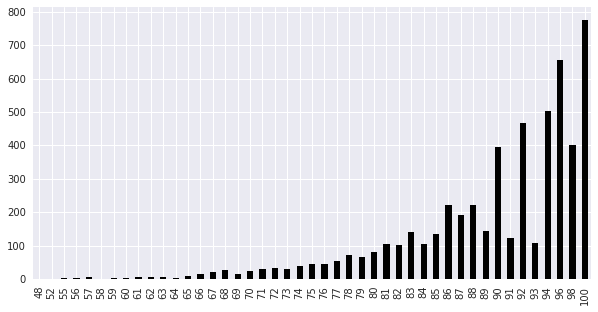

In [54]:
scoreCts = ins2016['score'].value_counts().sort_index()

# YOUR CODE HERE
scoreCts.plot(kind='bar', colormap='cubehelix', figsize=(10,5));

#plt.show()

#### Question 6b

Describe the qualities of the distribution of the inspections scores. Consider the mode(s), symmetry, tails, gaps, and anamolous values. Are there any unusual features of this distribution? What do your observation imply about the scores?

In [55]:
q6b_answer = r"""

The distribution has negative skewness, without a symmetry. Its mode is 100, and second mode is 96. 
There is a gap below score 48. For scores over 80, there are many more even numbers than odd numbers. 

"""

# YOUR CODE HERE

print(q6b_answer)



The distribution has negative skewness, without a symmetry. Its mode is 100, and second mode is 96. 
There is a gap below score 48. For scores over 80, there are many more even numbers than odd numbers. 




#### Question 6c

In assessing the granularity, we want to determine if there is one inspection per business per year. How many restaurants had two inspections? Three or more inspections? Create a dict mapping the number of inspections to the number of business ids with that many inspections.

*Hint: pandas Series have a to_dict() method.*

In [56]:
numIns2numIDs = ins2016.groupby('business_id').count().groupby('score').count().loc[:,"date"].to_dict()
numIns2numIDs

# YOUR CODE HERE


{1: 3031, 2: 1075, 3: 86}

Do not edit the empty cell below.

### Restaurants with multiple inspections

### Question 7

Some restaurants had 3 inspections in a calandar year, but not very many did. To examine the distribution of score among restaurants with two scores, we can look at the change in score from the first inspection.

#### Question 7a

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve?

First, make a dataframe called, `scores_pairs_by_business`, indexed by business_id (containing only business with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs ordered chronologically  `[first_score, second_score]`. 

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1. 

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary. 

The first few rows resulting table should look something like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>score_pair</th>
    </tr>
    <tr>
      <th>business_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>24</th>
      <td>[96, 98]</td>
    </tr>
    <tr>
      <th>45</th>
      <td>[78, 84]</td>
    </tr>
    <tr>
      <th>66</th>
      <td>[98, 100]</td>
    </tr>
    <tr>
      <th>67</th>
      <td>[87, 94]</td>
    </tr>
    <tr>
      <th>76</th>
      <td>[100, 98]</td>
    </tr>
  </tbody>
</table>

In [57]:
# For some odd reason, we can't just pass `list` into `.agg` so we define this function:
# You may or may not use it
def group_to_list(group):
    return list(group)

# YOUR CODE HERE
x = ins2016['business_id'].value_counts()
ins2 = pd.DataFrame(data = {'business_id': x[x==2].index})
scores_pairs_by_business = ins2016[ins2016['business_id'].isin(ins2['business_id'])].sort_values(['business_id',\
    'new_date']).loc[:,['business_id','score']].groupby('business_id').agg(group_to_list)
scores_pairs_by_business.columns = ['score_pair']
scores_pairs_by_business.head()

,score_pair
business_id,
24,"[96, 98]"
45,"[78, 84]"
66,"[98, 100]"
67,"[87, 94]"
76,"[100, 98]"


In [58]:
assert isinstance(scores_pairs_by_business, pd.DataFrame)
assert scores_pairs_by_business.columns == ['score_pair']


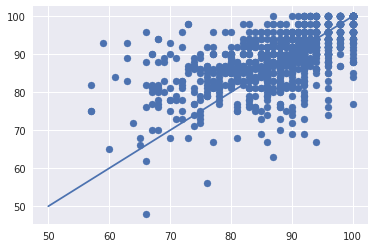

In [59]:
# Create scatter plot here.

# YOUR CODE HERE
s = pd.DataFrame(columns = ['col1', 'col2'])
s['col1'] = [i[0] for i in scores_pairs_by_business['score_pair']]
s['col2'] = [j[1] for j in scores_pairs_by_business['score_pair']]
plt.scatter(s['col1'], s['col2']);
x = np.linspace(50,100)
plt.plot(x, x, '-');

#### Question 7b

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.

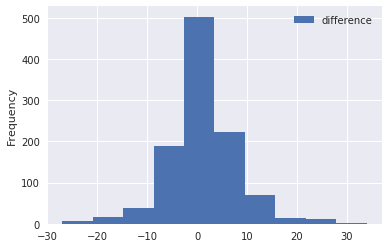

In [60]:
# Create histogram here
# YOUR CODE HERE
dif = pd.DataFrame(data = {'difference': s['col2'] - s['col1']})
dif.plot(kind = 'hist');

#### Question 7c

If a restaurant's score improves from the first to the second inspection, what do you expect to see in the scatter plot that you made in 7a? What do you see?

If a restaurant's score improves from the first to the second inspection, how would this be reflected in the histogram of the difference in the scores that you made in 7b? What do you see?

In [61]:
q7c_answer = r"""

In the scatter plot, I expect to see that the resturant lies above the y=x line, indicating an improvement. 
In the actual plot, I see slightly more restaurants improving than receding, and most restaurants have a small 
change.
In the histogram, the improvement is reflected by a count on a number larger than 0.
In the actual plot, I see many restuarants changing within 10 points, with slightly more improvements,and mean, 
median, mode all lie in that interval.

"""

# YOUR CODE HERE

print(q7c_answer)



In the scatter plot, I expect to see that the resturant lies above the y=x line, indicating an improvement. 
In the actual plot, I see slightly more restaurants improving than receding, and most restaurants have a small 
change.
In the histogram, the improvement is reflected by a count on a number larger than 0.
In the actual plot, I see many restuarants changing within 10 points, with slightly more improvements,and mean, 
median, mode all lie in that interval.




## Summary of the inspections data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that may restaurants have more than one inspection a year. In the future, we may want to roll some of the information about the inspections up to the business/restaurant level and join the inspection information with the business dataframe. For example, we could make maps of inspection scores for restaurants.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year. Our findings were a bit counterintuitive and we warrant further investigation. It also makes sense to learn more about the inspection process to help us understand the connections between scores from multiple inspections. 


## Congrats !

Congrats! You are finished with HW2.